# FS25 Course Project 1: Word embeddings / RNN

By David Hodel

## Introduction

In this notebook, I present my solution to the first course project of the FS25 NLP module @ HSLU.

The task is to train answer commonsense question using word embeddings and RNNs. The CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset is used for his purpose. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

## Setup

We first import the necessary libraries to run the code.

In [4]:
import os

from collections import Counter
from datetime import datetime

from datasets import load_dataset
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import numpy as np
from tqdm import trange
import gensim
from huggingface_hub import hf_hub_download
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torcheval.metrics as metrics

import torch
import nltk
import wandb

We set up a fixed random seed to ensure reproducibility.

In [5]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

We download the necessary files for the tokenizer from the `nltk` library and pretrained weights for the fasttext embedding model.

In [6]:
nltk.download('punkt_tab')
model_path = hf_hub_download("facebook/fasttext-en-vectors", "model.bin")

[nltk_data] Downloading package punkt_tab to /home/david/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


model.bin:   0%|          | 0.00/7.24G [00:00<?, ?B/s]

I decided to use fasttext embeddings as they natively support out-of-vocabulary words as it uses subword information.

In [7]:
fasttext_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = fasttext_model.wv

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
We separate the last 1'000 samples from the training set as the validation set and use the original validation set as the test set.

In [8]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, we want to take a look at the data to understand its structure and content.

In [9]:
datasets = {
  "train": train,
  "validation": valid,
  "test": test
}

We ensure that all three splits have the same structure and that the answers are in the same format.

In [10]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'C', 'E', 'A', 'D', 'B'}


We then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [11]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]['question']}")
    for j, choice in enumerate(data[0]['choices']['text']):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]['answerKey']}")
    print("=" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


We plot the distribution of the answer keys (`A` - `E`) to see if there's a clear imbalance or pattern.

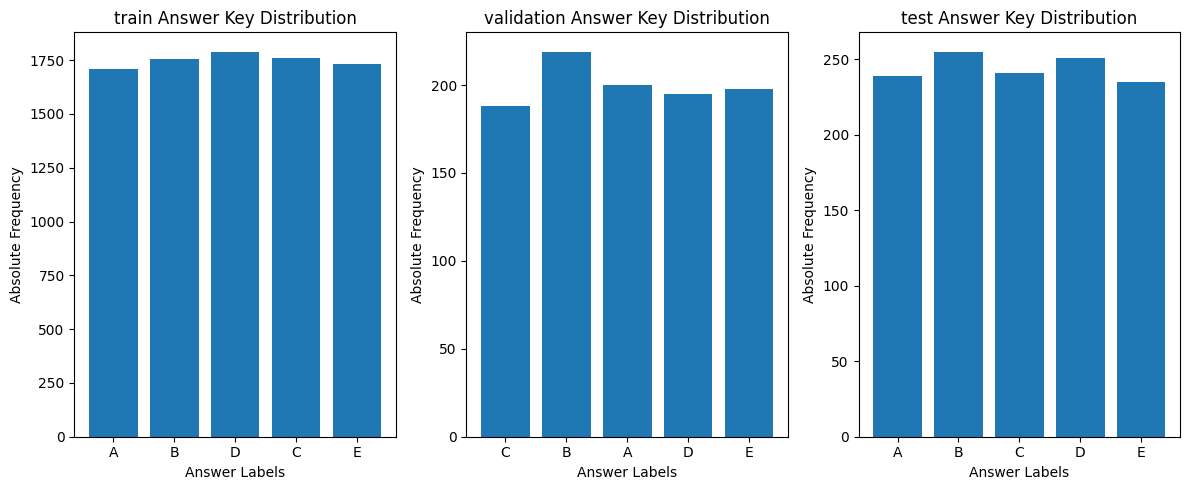

In [12]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    answer_counts = Counter([ex["answerKey"] for ex in data])

    plt.subplot(1, 3, i)
    plt.bar(answer_counts.keys(), answer_counts.values())
    plt.xlabel("Answer Labels")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Answer Key Distribution")

plt.tight_layout()
plt.show()

We see that the distribution is relatively balanced, with a slight preference for answer `B` in the validation and test set.

We also plot the distribution of the number of characters in the questions.

Min. question length in split train: 15, max. length: 376
Min. question length in split validation: 20, max. length: 270
Min. question length in split test: 21, max. length: 279


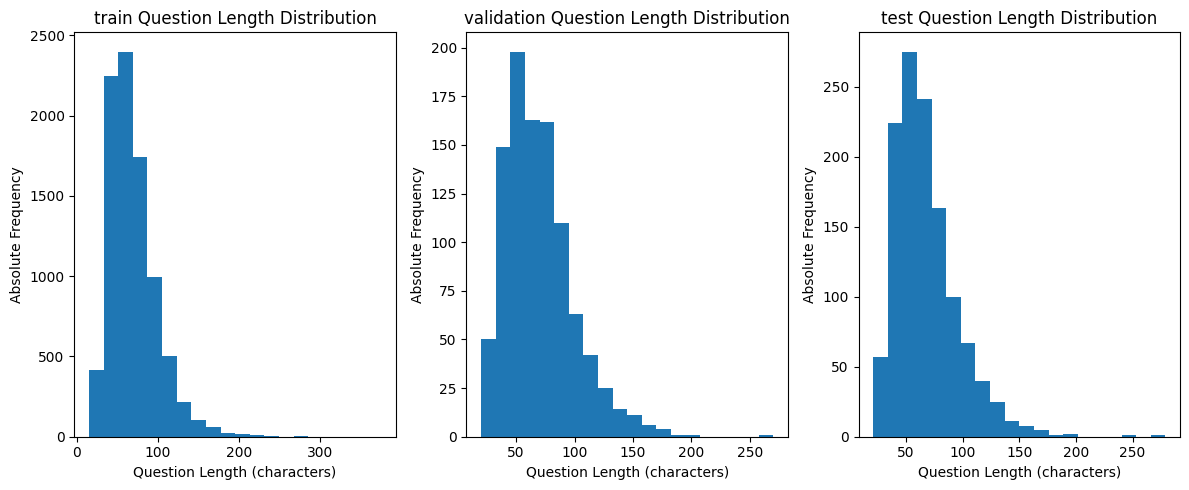

In [13]:
plt.figure(figsize=(12, 5))

for i, (split, data) in enumerate(datasets.items(), 1):
    question_lengths = [len(ex["question"]) for ex in data]

    plt.subplot(1, 3, i)
    plt.hist(question_lengths, bins=20)
    plt.xlabel("Question Length (characters)")
    plt.ylabel("Absolute Frequency")
    plt.title(f"{split} Question Length Distribution")
    print(f"Min. question length in split {split}: {min(question_lengths)}, max. length: {max(question_lengths)}")

plt.tight_layout()
plt.show()

## Preprocessing

Correct and justified decisions on:
o Tokenization
o Lowercasing, stemming, lemmatizing, stopword/punctuation removal
o Removal of unknown/other words
o Format cleaning (e.g. html-extracted text)
o Truncation
o Feature selection
o Input format: how is data passed to the model?
o Label format: what should the model predict?
o Batching, padding
o Vocabulary, embedding

First, we preprocess the raw text data to make it suitable for the model.

We use the word tokenizer from the `nltk` library to split the text into word tokens.

We don't lowercase the text as it may contain important information such as `I` or `US` and because fasttext can naturally handle different cases.

We also don't remove stopwords or punctuation as they may also contain important information for the model for answering the questions.

Stemming or lemmatization is not necessary as fasttext can handle different forms of words. Even more, it may be counterproductive as it may remove important information from the text such as time or location information.

Removal of unknown words is not necessary as fasttext word vectors are built from vectors of substrings of characters contained in it. This allows to build vectors even for misspelled words or concatenation of words.

As the longest question only has 376 characters, we don't need to truncate the text. During training we will use padding to ensure all strings have the same length.

The text in the dataset is already clean and doesn't contain any html tags we would need to remove and / or parse. 

In short: The only preprocessing we do is tokenization.

In [14]:
def preprocess_text(text):
  preprocessed = word_tokenize(text)
  return preprocessed

We then check out how the loaded embeddings look like and how many words are in the vocabulary.

In [15]:
print(f"Word embeddings vector size: {wv.vector_size}")
print(f"Word embeddings vocab size: {len(wv.index_to_key)}")

print(wv.index_to_key[:10])
print(wv.index_to_key[-5:])

Word embeddings vector size: 300
Word embeddings vocab size: 2000000
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']
['ldapmodify', 'sponde', 'hvm', 'GorceyBearTerritory.netSaturday', 'Zwicke']


Test the embeddings by looking up a word that certainly exists in the vocabulary and a word that doesn't exist in the vocabulary to see if it handles out-of-vocabulary words.

In [16]:
print(wv["and"])
print(wv["thiswordceratinlydoesntexist"])

[ 8.23911093e-03 -8.99027660e-02  2.65252870e-02 -8.55387747e-03
 -6.09397441e-02  6.75930129e-03  6.52322620e-02  1.06213633e-02
 -4.75259237e-02 -7.61148334e-03 -2.25875620e-03  9.08407965e-04
 -6.68869540e-03 -2.25828700e-02 -6.61593257e-03 -7.24807084e-02
  2.03068964e-02  2.14499757e-02 -5.07426150e-02  3.91916037e-02
  5.33207357e-02 -4.52754647e-03 -1.86902005e-03  5.57158291e-02
  1.46500766e-02 -5.70575595e-02  4.93949279e-04 -7.09158741e-03
  1.48559324e-02 -5.28307818e-02  2.84850523e-02 -4.96256426e-02
  2.22029127e-02  5.86468279e-02  2.13257503e-02  7.91368634e-03
  1.87332481e-02  9.18916687e-02 -2.77845450e-02  2.39473525e-02
  4.25748378e-02 -9.94171482e-03 -2.23485958e-02  8.55861679e-02
 -4.47648503e-02 -1.41877644e-02 -1.26887113e-04 -1.00239128e-01
 -1.24342320e-02  5.95488772e-02  2.35982426e-02  1.56282559e-02
  1.94263570e-02  8.58244579e-03  1.51532954e-02  4.16088402e-02
  1.98060516e-02 -7.46113062e-03 -3.07702627e-02 -2.10531931e-02
  2.74334885e-02 -4.17157

### Torch Dataloader and Dataset

#### Embeddings Model

For the model to be able to train on the data, we need to create a custom torch dataset that we can read from a torch dataloader.

We create a dataset that, when indexed, returns data in the following format:
1. The question as a tensor with dimensions `(embedding_dim)`
2. The choices as a tensor with dimensions `(5, embedding_dim)`
3. The correct answer encoded as a number as a tensor with dimensions `(1)`

To be able to reduce each question and each choice to a single tensor, we need to have a method to reduce the word embeddings to a single tensor.

In this case, we will use the mean of the word embeddings to represent the sentences. Each sentence is first preprocessed by tokenizing it and is then converted to word embeddings. The mean of the word embeddings is then calculated to represent the sentence.

In [17]:
def get_averaged_sentence_embedding(sentence):
    tokens = preprocess_text(sentence)

    word_vectors = [wv[word] for word in tokens]
    return np.mean(word_vectors, axis=0)  # average the word vectors

We also need a function to convert the answer keys to numbers (`A` -> 0, `B` -> 1, ..., `E` -> 4).

In [18]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

Finally, we create our custom dataset that performs the preprocessing and returns the data in the format described above.

In [19]:
class EmbeddingsCommonsenseQADataset(Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]

        average_question_embedding = get_averaged_sentence_embedding(example["question"])
        average_choice_embeddings = [get_averaged_sentence_embedding(choice) for choice in example["choices"]["text"]]
        average_choice_embeddings = np.array(average_choice_embeddings)

        question_tensor = torch.tensor(average_question_embedding).float()
        choices_tensor =  torch.tensor(average_choice_embeddings).float()
        answer_index = answer_key_to_index(example["answerKey"])
        return question_tensor, choices_tensor, torch.tensor(answer_index).long()

In [20]:
embeddings_train_dataset = EmbeddingsCommonsenseQADataset(train)
embeddings_valid_dataset = EmbeddingsCommonsenseQADataset(valid)

We load the first sample from the dataset to check the dimensions of the returned data.

In [21]:
example_question_tensor, example_choices_tensor, example_answer_index = embeddings_train_dataset[0]
print(example_question_tensor.shape, example_choices_tensor.shape, example_answer_index)

assert example_question_tensor.shape == (300,)
assert example_choices_tensor.shape == (5, 300)
assert example_answer_index.shape == ()

torch.Size([300]) torch.Size([5, 300]) tensor(0)


With this successful, we can now create a torch dataloader that reads from the custom dataset.

We use a batch size of 128. The data in the training set is shuffled to ensure that the model doesn't learn the order of the questions. The data in the validation and test set is not shuffled to ensure reproducibility.

In [80]:
embeddings_batch_size = 1024

embeddings_train_loader = DataLoader(embeddings_train_dataset, batch_size=embeddings_batch_size, shuffle=True, num_workers=8)
embeddings_valid_loader = DataLoader(embeddings_valid_dataset, batch_size=embeddings_batch_size, shuffle=False, num_workers=8)

We load the first batch from the dataloader to check the dimensions of the returned data and the format of the answers.

In [73]:
for batch in embeddings_train_loader:
    print(batch[0].shape, batch[1].shape, batch[2].shape, batch[2])
    assert batch[0].shape[0] == batch[1].shape[0] == batch[2].shape[0] == embeddings_batch_size
    break

torch.Size([256, 300]) torch.Size([256, 5, 300]) torch.Size([256]) tensor([0, 0, 1, 3, 1, 3, 2, 3, 4, 0, 0, 2, 1, 1, 0, 1, 3, 1, 4, 3, 1, 4, 1, 2,
        2, 2, 3, 3, 2, 3, 0, 4, 3, 0, 2, 2, 3, 1, 0, 4, 0, 4, 2, 2, 4, 2, 0, 3,
        4, 3, 3, 1, 4, 1, 4, 3, 4, 2, 3, 1, 2, 4, 3, 1, 0, 2, 2, 0, 4, 3, 2, 2,
        2, 4, 0, 4, 2, 2, 0, 1, 3, 4, 3, 0, 2, 3, 2, 3, 0, 4, 1, 0, 1, 0, 2, 3,
        4, 0, 2, 4, 3, 0, 2, 0, 2, 4, 4, 3, 0, 1, 3, 1, 0, 0, 4, 1, 0, 4, 1, 3,
        0, 1, 0, 2, 0, 0, 3, 3, 2, 1, 1, 0, 1, 0, 0, 4, 1, 1, 1, 2, 2, 2, 3, 1,
        1, 1, 3, 1, 4, 4, 0, 1, 3, 3, 1, 2, 0, 0, 2, 2, 0, 0, 0, 3, 2, 4, 2, 3,
        3, 4, 3, 1, 1, 3, 4, 3, 4, 1, 4, 0, 3, 0, 0, 2, 1, 2, 2, 1, 2, 2, 3, 1,
        4, 1, 3, 3, 3, 4, 1, 4, 2, 4, 0, 4, 3, 4, 3, 2, 0, 4, 4, 4, 4, 4, 1, 2,
        0, 1, 3, 0, 3, 1, 2, 4, 0, 0, 0, 3, 0, 0, 2, 3, 3, 1, 2, 0, 4, 0, 4, 4,
        2, 1, 2, 4, 4, 1, 3, 1, 4, 0, 0, 1, 1, 2, 3, 1])


#### RNN Model

In [24]:
embedding_dim = wv.vector_size

special_tokens = {
  "[EOQ]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of question
  "[EOC1]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 1
  "[EOC2]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 2
  "[EOC3]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 3
  "[EOC4]": np.random.uniform(-0.1, 0.1, embedding_dim), # end of choice 4
}

for token, vec in special_tokens.items():
    assert token not in wv.key_to_index, f"Token {token} already exists in the vocabulary"

wv.add_vectors(list(special_tokens.keys()), list(special_tokens.values()))

In [25]:
def get_sentence_embedding(sentence):
    tokens = preprocess_text(sentence)

    word_vectors = [wv[word] for word in tokens]
    return np.array(word_vectors)

In [26]:
class RNNCommonsenseQADataset(Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset
        self.special_separator_tokens = {
            "EOQ": torch.tensor(wv["[EOQ]"]).unsqueeze(0), # unsqueeze reshapes from (300) to (1, 300)
            "EOC1": torch.tensor(wv["[EOC1]"]).unsqueeze(0),
            "EOC2": torch.tensor(wv["[EOC2]"]).unsqueeze(0),
            "EOC3": torch.tensor(wv["[EOC3]"]).unsqueeze(0),
            "EOC4": torch.tensor(wv["[EOC4]"]).unsqueeze(0),
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return in format (question_tensor, EOQ, choice1_tensor, EOC1, choice2_tensor, EOC2, choice3_tensor, EOC3, choice4_tensor, EOC4, choice5_tensor)
        example = self.data[idx]

        question_embedding = get_sentence_embedding(example["question"])
        question_embedding = torch.tensor(question_embedding)
        choice_embeddings = [get_sentence_embedding(choice) for choice in example["choices"]["text"]]
        choice_embeddings = [torch.tensor(choice_embedding) for choice_embedding in choice_embeddings]

        concatenated = torch.cat([
            question_embedding,
            self.special_separator_tokens["EOQ"],
            choice_embeddings[0],
            self.special_separator_tokens["EOC1"],
            choice_embeddings[1],
            self.special_separator_tokens["EOC2"],
            choice_embeddings[2],
            self.special_separator_tokens["EOC3"],
            choice_embeddings[3],
            self.special_separator_tokens["EOC4"],
            choice_embeddings[4],
        ])

        answer_index = answer_key_to_index(example["answerKey"])

        return concatenated, torch.tensor(answer_index).long()

In [27]:
rnn_train_dataset = RNNCommonsenseQADataset(train)
rnn_valid_dataset = RNNCommonsenseQADataset(valid)

In [28]:
example_tensor, example_answer_index = rnn_train_dataset[0]
print(example_tensor.shape, example_answer_index)

assert example_tensor.shape[1] == embedding_dim
assert example_answer_index.shape == ()

torch.Size([35, 300]) tensor(0)


In [29]:
from torch.nn.utils.rnn import pad_sequence as torch_pad_sequence

def pad_collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Get sequence lengths before padding
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    # Pad sequences to max length in current batch
    padded_sequences = torch_pad_sequence(sequences, batch_first=True, padding_value=0)
    
    # Return padded sequences, original lengths, and labels
    return padded_sequences, lengths, torch.tensor(labels)

In [30]:
rnn_batch_size = 256

rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=rnn_batch_size, shuffle=True, num_workers=8, collate_fn=pad_collate_fn)
rnn_valid_loader = DataLoader(rnn_valid_dataset, batch_size=rnn_batch_size, shuffle=False, num_workers=8, collate_fn=pad_collate_fn)

In [31]:
for batch in rnn_train_loader:
    padded_sequences, lengths, labels = batch
    print(padded_sequences.shape, lengths.shape, labels.shape)
    assert padded_sequences.shape[0] == lengths.shape[0] == labels.shape[0] == rnn_batch_size
    break

torch.Size([256, 75, 300]) torch.Size([256]) torch.Size([256])


## Model

### Embeddings

The first model consists of two fully connected layers with a ReLU activation function in between.

It receives the question tensor (`(batch_size, embedding_dim)`) and the 5 choices tensors (`(batch_size, 5, embedding_dim)`) as input in the forward pass. The question tensor is then expanded to the same shape as the choice tensor and concatenated with it, resulting in a tensor of shape `(batch_size, 5, 2 * embedding_dim)`. This tensor is then passed through the two fully connected layers to get the logits for each choice (`(batch_size, 5)`).

Softmax is deliberately not applied to the logits because the chosen loss function, `CrossEntropyLoss`, already applies the softmax function to the logits.

In [32]:
class WordEmbeddingQAClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout_prob):
        super(WordEmbeddingQAClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.dropout = nn.Dropout(dropout_prob)

        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim) # the input dimension is doubled due to concatenation (question + choice)
        self.relu = nn.ReLU() # non-linearity
        self.fc2 = nn.Linear(hidden_dim, 1) # single score per candidate

    def forward(self, question, choices):
        # question: (batch_size, embedding_dim)
        # choices: (batch_size, 5, embedding_dim)

        # expand question to match the choices dimension
        question_expanded = question.unsqueeze(1).expand(-1, choices.size(1), -1) # (batch_size, 5, embedding_dim)
        
        # concatenate question and choice embeddings
        combined = torch.cat((question_expanded, choices), dim=2) # (batch_size, 5, 2*embedding_dim)

        # pass through the classifier
        x = self.fc1(combined)  # (batch_size, 5, hidden_dim)
        x = self.dropout(self.relu(x)) # (batch_size, 5, hidden_dim)
        x = self.fc2(x)         # (batch_size, 5, 1)
        return x.squeeze(-1)    # (batch_size, 5)

If available, we use a GPU for training.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [88]:
hidden_dim = 64
embeddings_dropout_prob = 0.2

embeddings_model = WordEmbeddingQAClassifier(embedding_dim=wv.vector_size, hidden_dim=hidden_dim, dropout_prob=embeddings_dropout_prob)
embeddings_model = embeddings_model.to(device)

print(embeddings_model)

WordEmbeddingQAClassifier(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=600, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


### RNN

In [35]:
class RNNQAClassifier(nn.Module):
    def __init__(self, embedding_dim, num_layers, bidirectional, rnn_hidden_dim, classifier_hidden_dim, device, dropout_prob):
        super(RNNQAClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.classifier_hidden_dim = classifier_hidden_dim
        self.device = device

        self.num_directions = 2 if bidirectional else 1

        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=rnn_hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.num_directions * rnn_hidden_dim, classifier_hidden_dim), # the input dimension is doubled due when the RNN is bidirectional
            nn.ReLU(), # non-linearity
            nn.Dropout(dropout_prob),
            nn.Linear(classifier_hidden_dim, 5) # single score per candidate
        )

    def forward(self, padded_sequences, sequence_lenghts): # sequence_lenghts is needed for pack_padded_sequence to handle variable length sequences
        # padded_sequences: (batch_size, max_sequence_length, embedding_dim)
        # sequence_lenghts: (batch_size,)
        sequence_lenghts = sequence_lenghts.cpu() # pack_padded_sequence requires the sequence lengths to be on the CPU
        packed_sequences = pack_padded_sequence(padded_sequences, sequence_lenghts, batch_first=True, enforce_sorted=False)

        packed_output, _ = self.rnn(packed_sequences)
        output, _ = pad_packed_sequence(packed_output, batch_first=True) # (batch_size, max_sequence_length, num_directions * rnn_hidden_dim)

        # get the last output for each sequence
        last_output = output[torch.arange(output.size(0)), sequence_lenghts - 1] # (batch_size, num_directions * rnn_hidden_dim)

        x = self.classifier(last_output) # (batch_size, 5)
        return x

In [36]:
rnn_hidden_dim = 256
classifier_hidden_dim = 128
rnn_dropout_prob = 0.3

rnn_model = RNNQAClassifier(embedding_dim=wv.vector_size, num_layers=2, bidirectional=True, rnn_hidden_dim=rnn_hidden_dim, classifier_hidden_dim=classifier_hidden_dim, device=device, dropout_prob=rnn_dropout_prob)
rnn_model = rnn_model.to(device)

print(rnn_model)

RNNQAClassifier(
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)


In [37]:
for test_batch in rnn_train_loader:
    test_padded_sequences, test_lengths, test_labels = test_batch
    test_padded_sequences, test_labels = test_padded_sequences.to(device), test_labels.to(device)

    print(test_padded_sequences.shape, test_lengths.shape, test_labels.shape)

    test_output = rnn_model(test_padded_sequences, test_lengths)
    print(test_output.shape)

    break

torch.Size([256, 60, 300]) torch.Size([256]) torch.Size([256])
torch.Size([256, 5])


## Training

### Initialize Weights & Biases experiment tracking

For tracking the training process, we use Weights & Biases. We first have to log in to our account and initialize a new experiment.

In [38]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/david/.netrc
wandb: Currently logged in as: davidhodel (dhodel-hslu-nlp) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [89]:
embedding_run = wandb.init(
  project="hslu-fs25-nlp-qa",
  entity="dhodel-hslu-nlp",
  name=f"word-embedding-qa-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "word-embedding",
    "embedding_dim": embeddings_model.embedding_dim,
    "hidden_dim": embeddings_model.hidden_dim,
    "initial_learning_rate": 5e-4,
    "max_learning_rate": 5e-3,
    "batch_size": embeddings_batch_size,
    "epochs": 100,
    "weight_decay": 1e-2,
    "dropout_prob": embeddings_dropout_prob,
  },
  reinit=True,
)

print(f"Run name: {embedding_run.name}")

Run name: word-embedding-qa-2025-03-28T11:01:07


To hook up the model to Weights & Biases, we call the `wandb.watch()` function and instruct it to watch the model.

In [90]:
wandb.watch(embeddings_model, log="all")

We use cross entropy loss as the loss function as it is well suited for multi-class classification tasks, such as this one.

As the optimizer we chose AdamW as it has been shown to perform well in practice. Its integrated weight decay is also beneficial as it helps to prevent overfitting.

For the learning rate scheduler, we use the `OneCycleLR` scheduler. It increases the learning rate from an initial learning rate to some maximum value and then from that maximum rate to some minimum learning rate much lower than the initial one. This warmup phase has been shown to improve the training process and the generalization of the model.

In [91]:
embeddings_num_epochs = embedding_run.config.epochs

embeddings_criterion = nn.CrossEntropyLoss()
embeddings_optimizer = torch.optim.AdamW(embeddings_model.parameters(), lr=embedding_run.config.initial_learning_rate, weight_decay=embedding_run.config.weight_decay)
embeddings_scheduler = torch.optim.lr_scheduler.OneCycleLR(embeddings_optimizer, max_lr=embedding_run.config.max_learning_rate, steps_per_epoch=len(embeddings_train_loader), epochs=embeddings_num_epochs+1)

Next we define the function to save model checkpoints. We save the weights of the model, the optimizer, the scheduler, and the current epoch.
Sving checkpoints is important as it allows us to resume training from a certain point in case the training process is interrupted.
Furthermore, it allows us to load the best model after training.

For this, we save a checkpoint after each epoch and when a new highest validation accuracy is reached.

In [85]:
def save_checkpoint(model, optimizer, epoch, scheduler, save_model_path, checkpoint_name):
  checkpoint_name = f"{checkpoint_name}.pt"
  save_path = os.path.join(save_model_path, checkpoint_name)

  torch.save({
      "epoch": epoch,
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
      "scheduler_state_dict": scheduler.state_dict(),
  }, save_path)

embeddings_checkpoints_path = "./checkpoints/embeddings"
rnn_checkpoints_path = "./checkpoints/rnn"

os.makedirs(embeddings_checkpoints_path, exist_ok=True)
os.makedirs(rnn_checkpoints_path, exist_ok=True)

Finally, we can train the model: We iterate over the training set and calculate the loss for each batch. We then backpropagate the loss and update the weights of the model. After iterating over the entire training set, we evaluate the model on the validation set and log all relevant metrics to Weights & Biases.

In [92]:
def run_training_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, checkpoints_path, log_wandb=True):
    best_val_accuracy = 0.0

    for epoch in (pbar := trange(epochs)):
        pbar.set_description(f"Epoch {epoch+1}/{epochs}")

        # Initialize torcheval metrics for this epoch
        train_accuracy_metric = metrics.MulticlassAccuracy(num_classes=5)
        val_accuracy_metric = metrics.MulticlassAccuracy(num_classes=5)
        
        # Set metrics to the correct device
        train_accuracy_metric.to(device)
        val_accuracy_metric.to(device)
        
        # For loss tracking
        train_total_loss = 0.0
        val_total_loss = 0.0

        model.train()

        for batch in train_loader:
            optimizer.zero_grad() # zero all the parameter gradients

            batch = [tensor.to(device) for tensor in batch]
            y_batch = batch.pop() # get the labels

            # Forward pass
            outputs = model(*batch)

            # Compute loss
            train_batch_loss = criterion(outputs, y_batch)
            train_total_loss += train_batch_loss.item()
            
            # Update accuracy metric with torcheval
            train_accuracy_metric.update(outputs, y_batch)

            # Backward pass
            train_batch_loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

        # Calculate train statistics
        avg_train_loss = train_total_loss / len(train_loader) # average loss per batch
        train_accuracy = train_accuracy_metric.compute().item() # from torcheval

        # Evaluate
        model.eval()
        val_total_loss = 0.0

        with torch.no_grad():
            for batch in valid_loader:
                batch = [tensor.to(device) for tensor in batch]
                y_batch = batch.pop()

                val_outputs = model(*batch)

                # Calculate validation loss
                val_batch_loss = criterion(val_outputs, y_batch)
                val_total_loss += val_batch_loss.item()
                
                # Update accuracy metric with torcheval
                val_accuracy_metric.update(val_outputs, y_batch)

        # Calculate validation statistics
        avg_val_loss = val_total_loss / len(valid_loader) # average loss per batch
        val_accuracy = val_accuracy_metric.compute().item() # from torcheval

        # save regular checkpoint after each epoch
        save_checkpoint(model, optimizer, epoch, scheduler, checkpoints_path, "regular_checkpoint")

        # save additional checkpoints for best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_checkpoint(model, optimizer, epoch, scheduler, checkpoints_path, "best_val_acc")

        pbar.set_postfix({"train_loss": avg_train_loss, "train_acc": train_accuracy, "val_acc": val_accuracy})

        if log_wandb:
            # Log metrics to wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr'], # current learning rate
            })

    if log_wandb:
        wandb.finish()

In [93]:
run_training_loop(embeddings_model, embeddings_criterion, embeddings_optimizer, embeddings_scheduler, embeddings_train_loader, embeddings_valid_loader, embeddings_num_epochs, embeddings_checkpoints_path, log_wandb=True)

Epoch 100/100: 100%|██████████| 100/100 [06:15<00:00,  3.75s/it, train_loss=0.955, train_acc=0.639, val_acc=0.234]


epoch,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
learning_rate,▁▁▁▂▂▃▃▄▅▆▇▇▇███████▇▇▇▆▆▆▆▆▆▅▃▃▃▃▂▂▂▁▁▁
train_accuracy,▁▁▁▁▁▂▂▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████
train_loss,█████▇▇▇▇▇▆▆▆▅▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂█▇▄▅▂▄▆▆▇▅▆▅▂▇▆▅▄▁▂▂▆▃▅▃▄▃▅▃▃▄▄▄▃▅▄▄▅▄▄
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇████████
epoch,99
learning_rate,0.0
train_accuracy,0.6394
train_loss,0.95543
val_accuracy,0.234


### RNN

In [ ]:
rnn_run = wandb.init(
  project="hslu-fs25-nlp-qa",
  entity="dhodel-hslu-nlp",
  name=f"rnn-qa-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "rnn",
    "embedding_dim": rnn_model.embedding_dim,
    "rnn_hidden_dim": rnn_model.rnn_hidden_dim,
    "classifier_hidden_dim": rnn_model.classifier_hidden_dim,
    "initial_learning_rate": 5e-5,
    "max_learning_rate": 5e-4,
    "batch_size": rnn_batch_size,
    "epochs": 50,
    "weight_decay": 1e-2,
    "dropout_prob": rnn_dropout_prob
  },
  reinit=True,
)

print(f"Run name: {rnn_run.name}")

wandb.watch(rnn_model, log="all")

Run name: rnn-qa-2025-03-27T16:20:59


In [43]:
rnn_num_epochs = rnn_run.config.epochs

rnn_criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=rnn_run.config.initial_learning_rate, weight_decay=rnn_run.config.weight_decay)
rnn_scheduler = torch.optim.lr_scheduler.OneCycleLR(rnn_optimizer, max_lr=rnn_run.config.max_learning_rate, steps_per_epoch=len(rnn_train_loader), epochs=rnn_num_epochs+1)

In [44]:
run_training_loop(rnn_model, rnn_criterion, rnn_optimizer, rnn_scheduler, rnn_train_loader, rnn_valid_loader, rnn_num_epochs, rnn_checkpoints_path, log_wandb=True)

Epoch 50/50: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it, train_loss=0.000347, train_acc=1, val_acc=0.184]   


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▂▂▂▃▄▅▆▆▇████████▇▇▇▇▆▆▆▅▅▅▄▄▃▂▂▂▂▁▁▁▁▁
train_accuracy,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇██████████████████
train_loss,██████████▇▇▇▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆▆▆█▃▃▇▂▄▆▁█▇▅▆▅▃▃▄▄▄▄▃▆▄▄▅▄▄▃▄▄▄▄▄▄▄▄▄▄
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██████████
epoch,49
learning_rate,1e-05
train_accuracy,1
train_loss,0.00035
val_accuracy,0.184


## Evaluation

In this chapter we evaluate the two models on the test set to get a feeling of how well they perform on unseen data.

First, we define a method to load a model from a checkpoint on disk.

In [45]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model, checkpoint["epoch"]

With this, we can load the best model from the embeddings model training and set it to evaluation mode.

In [46]:
best_embeddings_checkpoint_path = os.path.join(embeddings_checkpoints_path, "best_val_acc.pt")
embeddings_model, best_embeddings_epoch = load_checkpoint(embeddings_model, best_embeddings_checkpoint_path)
embeddings_model = embeddings_model.to(device)
embeddings_model.eval()
print(f"Loaded embeddings model checkpoint from epoch {best_embeddings_epoch}")

Loaded embeddings model checkpoint from epoch 27


The same goes for the RNN model.

In [47]:
best_rnn_checkpoint_path = os.path.join(rnn_checkpoints_path, "best_val_acc.pt")
rnn_model, best_rnn_epoch = load_checkpoint(rnn_model, best_rnn_checkpoint_path)
rnn_model = rnn_model.to(device)
rnn_model.eval()
print(f"Loaded RNN model checkpoint from epoch {best_rnn_epoch}")

Loaded RNN model checkpoint from epoch 3


We prepare the datasets and dataloaders with the test data for both models to be used for evaluation.

In [48]:
embeddings_test_dataset = EmbeddingsCommonsenseQADataset(test)
embeddings_test_loader = DataLoader(embeddings_test_dataset, batch_size=embeddings_batch_size, shuffle=False, num_workers=8)

rnn_test_dataset = RNNCommonsenseQADataset(test)
rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=rnn_batch_size, shuffle=False, num_workers=8, collate_fn=pad_collate_fn)

Similar to the training loop, we will define a function to evaluate the model on the test set. This function will calculate the accuracy and return the predictions and true labels for further analysis.

In [49]:
def evaluate_model(model, test_loader):
    model.eval()
    
    # Initialize torcheval metrics
    accuracy_metric = metrics.MulticlassAccuracy(num_classes=5)
    precision_metric = metrics.MulticlassPrecision(num_classes=5)
    recall_metric = metrics.MulticlassRecall(num_classes=5)
    f1_metric = metrics.MulticlassF1Score(num_classes=5)
    
    # Move metrics to the correct device
    accuracy_metric.to(device)
    precision_metric.to(device)
    recall_metric.to(device)
    f1_metric.to(device)
    
    all_predictions = []
    all_labels = []
    all_outputs = []  # Store raw model outputs for further analysis

    with torch.no_grad():
        for batch in test_loader:
            batch = [tensor.to(device) for tensor in batch]
            y_batch = batch.pop()

            # Forward pass
            outputs = model(*batch)
            
            # Update all metrics
            accuracy_metric.update(outputs, y_batch)
            precision_metric.update(outputs, y_batch)
            recall_metric.update(outputs, y_batch)
            f1_metric.update(outputs, y_batch)
            
            # Get predictions for further analysis
            predictions = torch.argmax(outputs, dim=1)
            
            # Store predictions, outputs and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_outputs.append(outputs.cpu().detach())

    # Compute all metrics
    metrics_dict = {
        "accuracy": accuracy_metric.compute().item(),
        "precision": precision_metric.compute().tolist(),  # Per-class precision
        "recall": recall_metric.compute().tolist(),        # Per-class recall
        "f1": f1_metric.compute().tolist(),                # Per-class F1
        "macro_precision": torch.mean(precision_metric.compute()).item(),
        "macro_recall": torch.mean(recall_metric.compute()).item(),
        "macro_f1": torch.mean(f1_metric.compute()).item()
    }
    
    return metrics_dict, all_predictions, all_labels, torch.cat(all_outputs)

We run the evaluation function for both models and save its results.

In [50]:
embeddings_metrics, embeddings_predictions, embeddings_labels, embeddings_outputs = evaluate_model(embeddings_model, embeddings_test_loader)
rnn_metrics, rnn_predictions, rnn_labels, rnn_outputs = evaluate_model(rnn_model, rnn_test_loader)

embeddings_labels_tensor = torch.tensor(embeddings_labels)
embeddings_predictions_tensor = torch.tensor(embeddings_predictions)
rnn_labels_tensor = torch.tensor(rnn_labels)
rnn_predictions_tensor = torch.tensor(rnn_predictions)

We're interested in the accuracy of the models on the test set to see how well they generalize to unseen data.
The absolute difference in accuracy between the two models is also of interest to see which model performs better.

In [53]:
print(f"Embeddings Model Test Accuracy: {embeddings_metrics['accuracy']:.4f}")
print(f"RNN Model Test Accuracy: {rnn_metrics['accuracy']:.4f}")
print(f"Difference: {abs(embeddings_metrics['accuracy'] - rnn_metrics['accuracy']):.4f} in favor of the {'Embeddings' if embeddings_metrics['accuracy'] > rnn_metrics['accuracy'] else 'RNN'} model")

===== Model Comparison =====
Embeddings Model Test Accuracy: 0.2867
RNN Model Test Accuracy: 0.1990
Difference: 0.0876 in favor of the Embeddings model


In [52]:
print(f"Embeddings Model - Macro Precision: {embeddings_metrics['macro_precision']:.4f}, Macro Recall: {embeddings_metrics['macro_recall']:.4f}, Macro F1: {embeddings_metrics['macro_f1']:.4f}")
print(f"RNN Model - Macro Precision: {rnn_metrics['macro_precision']:.4f}, Macro Recall: {rnn_metrics['macro_recall']:.4f}, Macro F1: {rnn_metrics['macro_f1']:.4f}")

Embeddings Model - Macro Precision: 0.2867, Macro Recall: 0.2867, Macro F1: 0.2867
RNN Model - Macro Precision: 0.1990, Macro Recall: 0.1990, Macro F1: 0.1990


For this, we first create a mapping from the answer index back to the answer key (`0` -> `A`, `1` -> `B`, ..., `4` -> `E`). Then we use `sklearn`'s `classification_report` function to calculate the precision, recall, and F1 score for each class.

Another interesting part is the agreement between the two models. We calculate the percentage of questions where both models agree on the answer.

In [56]:
agreements = np.sum(np.array(embeddings_predictions) == np.array(rnn_predictions))
agreement_percentage = agreements / len(embeddings_predictions) * 100
print(f"\nModels agree on {agreements} out of {len(embeddings_predictions)} examples ({agreement_percentage:.2f}%)")


Models agree on 258 out of 1221 examples (21.13%)


The per-class performance is also important to see if the models perform better on certain classes than others. This can give us insights into the strengths and weaknesses of the models.

For this, we first create a mapping from the answer index back to the answer key (`0` -> `A`, `1` -> `B`, ..., `4` -> `E`). Then we use `sklearn`'s `classification_report` function to calculate the precision, recall, and F1 score for each class.

Finally, we plot the confusion matrix to see where the models make mistakes.

In [ ]:
label_mapping = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
label_names = list(label_mapping.values())

In [60]:
print("\nEmbeddings Model Classification Report:")
print(classification_report(embeddings_labels, embeddings_predictions, target_names=label_names, zero_division=0))

print("\nRNN Model Classification Report:")
print(classification_report(rnn_labels, rnn_predictions, target_names=label_names, zero_division=0))


Embeddings Model Classification Report:
              precision    recall  f1-score   support

           A       0.30      0.30      0.30       239
           B       0.28      0.28      0.28       255
           C       0.27      0.27      0.27       241
           D       0.28      0.29      0.28       251
           E       0.30      0.30      0.30       235

    accuracy                           0.29      1221
   macro avg       0.29      0.29      0.29      1221
weighted avg       0.29      0.29      0.29      1221


RNN Model Classification Report:
              precision    recall  f1-score   support

           A       0.33      0.04      0.07       239
           B       0.25      0.05      0.09       255
           C       0.19      0.69      0.30       241
           D       0.23      0.04      0.06       251
           E       0.19      0.19      0.19       235

    accuracy                           0.20      1221
   macro avg       0.24      0.20      0.14      1221
we

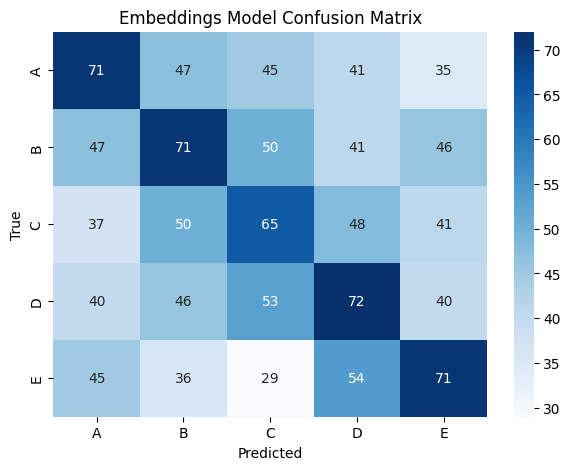

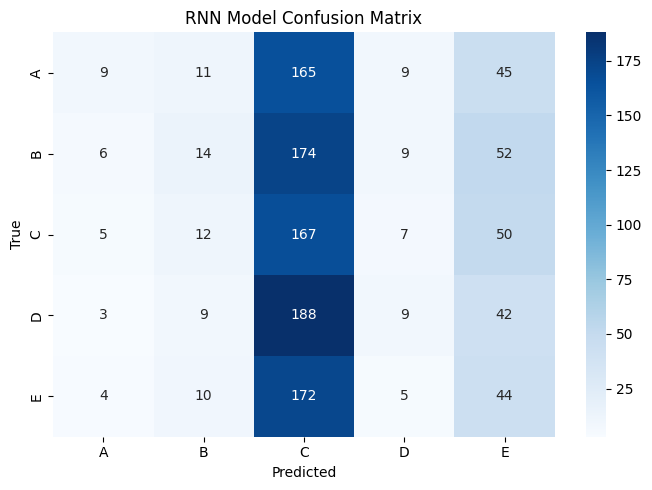

In [67]:
embeddings_cm = confusion_matrix(embeddings_labels, embeddings_predictions)
rnn_cm = confusion_matrix(rnn_labels, rnn_predictions)

embeddings_cm_fig, embeddings_cm_ax = plt.subplots(figsize=(7, 5))
sns.heatmap(embeddings_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names, ax=embeddings_cm_ax)
embeddings_cm_ax.set_title("Embeddings Model Confusion Matrix")
embeddings_cm_ax.set_xlabel("Predicted")
embeddings_cm_ax.set_ylabel("True")

rnn_cm_fig, rnn_cm_ax = plt.subplots(figsize=(7, 5))
sns.heatmap(rnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names, ax=rnn_cm_ax)
rnn_cm_ax.set_title("RNN Model Confusion Matrix")
rnn_cm_ax.set_xlabel("Predicted")
rnn_cm_ax.set_ylabel("True")

plt.tight_layout()
plt.show()

We display a couple of examples where the models disagree to see if there's a obvious pattern.

In [68]:
# Visualize examples where models disagree
disagreement_indices = np.where(np.array(embeddings_predictions) != np.array(rnn_predictions))[0]
print(f"\nExamples where models disagree ({len(disagreement_indices)} cases):")

# Show a few examples
num_examples_to_show = 5
for i in range(num_examples_to_show):
    idx = int(disagreement_indices[i])
    example = test[idx]
    print(f"\nQuestion: {example['question']}")
    for j, choice in enumerate(example["choices"]["text"]):
        print(f"{chr(65+j)}) {choice}")
    print(f"True Answer: {example['answerKey']}")
    print(f"Embeddings Model Prediction: {label_mapping[embeddings_predictions[idx]]}")
    print(f"RNN Model Prediction: {label_mapping[rnn_predictions[idx]]}")
    print("-" * 80)


Examples where models disagree (963 cases):

Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
True Answer: A
Embeddings Model Prediction: A
RNN Model Prediction: C
--------------------------------------------------------------------------------

Question: What do people aim to do at work?
A) complete job
B) learn from each other
C) kill animals
D) wear hats
E) talk to each other
True Answer: A
Embeddings Model Prediction: C
RNN Model Prediction: B
--------------------------------------------------------------------------------

Question: Where are  you likely to find a hamburger?
A) fast food restaurant
B) pizza
C) ground up dead cows
D) mouth
E) cow carcus
True Answer: A
Embeddings Model Prediction: B
RNN Model Prediction: C
--------------------------------------------------------------------------------

Question: What do animals do when an enemy is approa

In [69]:
# Calculate examples where only one model is correct
embeddings_correct = np.array(embeddings_predictions) == np.array(embeddings_labels)
rnn_correct = np.array(rnn_predictions) == np.array(rnn_labels)

only_embeddings_correct = np.logical_and(embeddings_correct, np.logical_not(rnn_correct))
only_rnn_correct = np.logical_and(rnn_correct, np.logical_not(embeddings_correct))

print(f"\nOnly Embeddings Model Correct: {np.sum(only_embeddings_correct)} examples")
print(f"Only RNN Model Correct: {np.sum(only_rnn_correct)} examples")
print(f"Both Models Correct: {np.sum(np.logical_and(embeddings_correct, rnn_correct))} examples")
print(f"Both Models Incorrect: {np.sum(np.logical_and(np.logical_not(embeddings_correct), np.logical_not(rnn_correct)))} examples")


Only Embeddings Model Correct: 283 examples
Only RNN Model Correct: 176 examples
Both Models Correct: 67 examples
Both Models Incorrect: 695 examples


In [70]:
# Save results to wandb for tracking
final_results = {
    "embeddings_test_accuracy": embeddings_metrics['accuracy'],
    "rnn_test_accuracy": rnn_metrics['accuracy'],
    "embeddings_macro_f1": embeddings_metrics['macro_f1'],
    "rnn_macro_f1": rnn_metrics['macro_f1'],
    "model_agreement_percentage": agreement_percentage,
    "only_embeddings_correct": np.sum(only_embeddings_correct),
    "only_rnn_correct": np.sum(only_rnn_correct),
    "both_correct": np.sum(np.logical_and(embeddings_correct, rnn_correct)),
    "both_incorrect": np.sum(np.logical_and(np.logical_not(embeddings_correct), np.logical_not(rnn_correct))),
}

# Initialize a new wandb run for evaluation results
eval_run = wandb.init(
    project="hslu-fs25-nlp-qa",
    entity="dhodel-hslu-nlp",
    name=f"evaluation-comparison-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    config={
        "embeddings_epoch": best_embeddings_epoch,
        "rnn_epoch": best_rnn_epoch
    },
    reinit=True,
)

# Log the evaluation metrics
wandb.log(final_results)
wandb.log({"embeddings_confusion_matrix": wandb.Image(embeddings_cm_fig)})
wandb.log({"rnn_confusion_matrix": wandb.Image(rnn_cm_fig)})
wandb.finish()

both_correct,▁
both_incorrect,▁
embeddings_macro_f1,▁
embeddings_test_accuracy,▁
model_agreement_percentage,▁
only_embeddings_correct,▁
only_rnn_correct,▁
rnn_macro_f1,▁
rnn_test_accuracy,▁
both_correct,67
both_incorrect,695


## Interpretation